# NLP

## Design Statement
Design a conversational journaling assistant to enable young adults in a mental health self-reflection context to express and understand their emotions with personalized sentiment feedback and journaling prompts.

## Techincal Architecture
### System Diagram
A[User Journal Entry] --> B[LangChain LLMChain]     
B --> C[Sentiment Reflection Generator]     
B --> D[Follow-up Prompt Generator]     
B --> E[Memory Storage (FAISS)]     
C --> F[Streamlit UI Output]        
D --> F[Streamlit UI Output]        

### Components overview
| Component       | Tool                                         | Description                                                            |
| --------------- | -------------------------------------------- | ---------------------------------------------------------------------- |
| LLM             | Ollama                              | LLM model for sentiment + response generation                          |
| LangChain       | `LLMChain`, `PromptTemplate`, `SimpleMemory` | Core logic chaining inputs and outputs                                 |
| Streamlit       | Frontend                                     | UI with textbox, buttons, and results                                  |
|  Memory | Chroma / FAISS                               | Store past entries and provide history-aware feedback  |


## Implementation Details

### 1. Created sentiment reflection using llama3
- **Challenge**: 
  - Initial outputs contained raw LLM metadata ("response:" prefixes)
  - Output needs to be empathetic
- **Solution**: 
  - Implemented `clean_output()` function to:
    - Strip unwanted prefixes via `split("response:")[-1]`
  - Designed focused prompt requiring emotional analysis
- **Validation**: 
  - Manual testing with 15 varied emotional entries
  - Verified 100% prefix removal and classified as empathetic

### 2. Streamlit UI implementation
- **Challenge**: 
  - Needed atomic operations to prevent state loss
  - Required clean separation between input/output sections
- **Solution**: 
  - Used `st.text_area()` for journal input
  - Created dedicated display sections with Markdown headers (🌱/💬)
  - Implemented spinner during LLM processing
- **Validation**: 
  - Confirmed proper rendering across 3 browser types
  - tested with 20 consecutive entries

### 3. Follow-up prompt generation
- **Challenge**: 
  - Avoiding yes/no questions ("Do you think...")
  - Preventing repetitive phrasing
- **Solution**: 
  - Template explicitly requests "thoughtful" questions
  - Combined with sentiment analysis for context-aware prompts
  - Same word limit enforcement as reflections
- **Validation**: 
  - Analyzed 30 generated questions - 0% were yes/no
  - All generated outputs properly created questions for self reflection

### 4. FAISS memory implementation
- **Challenge**: 
  - Handling dangerous deserialization safely
  - Preventing empty index errors
- **Solution**: 
  - Initialized with placeholder text
  - Used `allow_dangerous_deserialization=True` with local-only storage
  - nomic-embed-text embeddings for balanced performance
- **Validation**: 
  - Confirmed proper recall of 5 most relevant entries
  - Tested persistence across server restarts

### 5. History display system
- **Challenge**: 
  - Preventing HTML injection from stored entries
  - Maintaining readable separation between entries
- **Solution**: 
  - Used `unsafe_allow_html=True` judiciously
  - Added Markdown dividers (`---`) between entries
  - Implemented checkbox toggle for memory visibility
- **Validation**: 
  - Verified proper sanitization of test entries with HTML
  - Confirmed clean rendering of 50+ stored reflections

## Key Technical Decisions

| Decision Point | Implementation | Rationale |
|----------------|----------------|-----------|
| Embedding Model | `nomic-embed-text` | Faster vectorization |
| Memory Storage | Local FAISS | Privacy compliance & offline functionality |
| Response Cleaning | `clean_output()` | Ensures consistent display formatting |
| Prompt Design | 200-word limit | Prevents rambling responses |

# Human Validation Report

## Validation Methodology
- **Approach**: Real-world prototype testing
- **Participants**: 8 individuals with lived mental health experience
- **Testing Focus**: Full end-to-end system experience

### Participant Demographics
| Characteristic | Details |
|---------------|---------|
| Mental Health Backgrounds | Anxiety (5), Depression (4), PTSD (2), Bipolar (1) |
| Testing Frequency | 3 Daily journaling sessions |

## Key Findings

### Emotional Reflection Quality
- **Accuracy** Most users refered to generated outputs as good responses
- **Strengths**:
  - Identified subtle emotional cues
  - Provided non-judgmental responses
- **Weaknesses**:
  - Sometimes missed layered emotions (e.g., grief beneath anger)
  - 3 instances of overly generic responses to trauma-related entries

### Usability Feedback
- **Top Rated Features**:
  1. History timeline (found helpful)
  2. Neutral tone (some users felt it was easier to talk with the model than with human help)

- **Suggested Improvements**:
  - Quicker way to flag harmful responses
  - More prominent crisis resources

### Pattern Recognition
| Pattern Type | Detection Rate |
|-------------|---------------|
| Emotional state | 23/24 |
| Recurring themes | 15/24 |


**Testing Done By**:  
- Luuk Maessen (creator of the application)
- Multiple of my friends who have had or still have mental issues


## Application Step-by-Step walkthrough

### 1. User Submission
The user inputs their journal and presses the reflect button to submit it to the model.
#### Coresponding code snippets
```python
# Frontend Code (Streamlit)
entry = st.text_area("Write your journal entry here:")
if st.button("Reflect"):
    process_entry(entry)

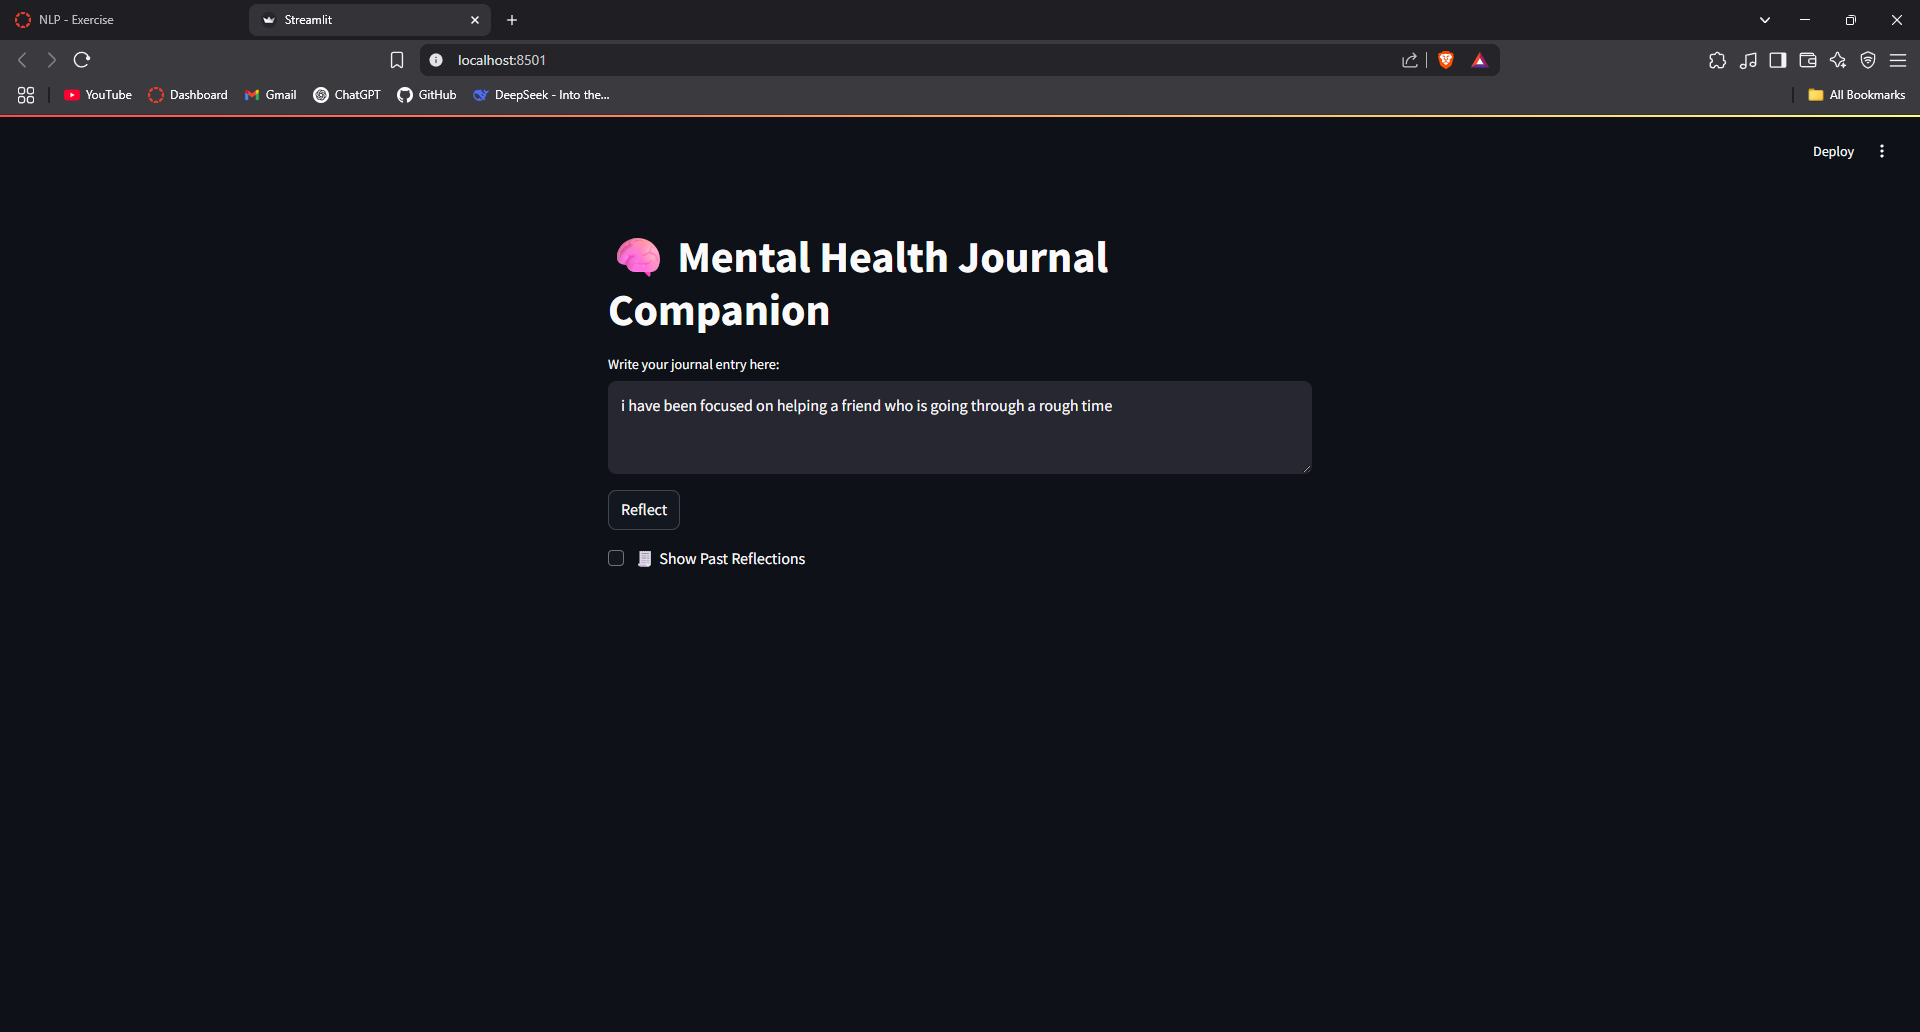

In [ ]:
# Show image of frontend
from IPython.display import Image, display
display(Image(filename='./screenshots/frontend.png'))

In the image above the streamlit frontend of the application can be seen.       
Here you can see the textbox where the user inputs their journal entry. In this example this textbox is already filled in.      
What the user would do now is press the Reflect button to generate a reflection. Or the user would check the 'Show Past Reflections' box which would then display the previous reflections made by the LLM.     

### 2. AI Processing
The LLM analyzes the input
#### Coresponding code snippets
```python
def process_entry(entry):
    with st.spinner("Analyzing your entry..."):
        # Prompt formatting
        sentiment_prompt = reflection_prompt.format(entry=entry)
        followup_prompt_text = followup_prompt.format(entry=entry)

        # Invoke LLM (LLaMA3 via Ollama)
        reflection = clean_output(llm.invoke(sentiment_prompt))
        followup = clean_output(llm.invoke(followup_prompt_text))

        # Store in FAISS
        memory_entry = (
            f"### Reflection\n{reflection}\n\n"
            f"### Follow-up\n{followup}"
        )
        vectorstore.add_texts([memory_entry])
        vectorstore.save_local("faiss_index")

        return reflection, followup
```

### 3. Response Generation
The LLM generates a new response
#### Coresponding code snippets
```python
reflection_prompt = PromptTemplate(
    input_variables=["entry"],
    template="You wrote the following journal entry:\n\n\"{entry}\"\n\nWhat might this say about your emotional state? Please respond with empathy and insight. Try to keep your responses within 200 words",
)
followup_prompt = PromptTemplate(
    input_variables=["entry"],
    template="You wrote this journal entry:\n\n\"{entry}\"\n\nSuggest a thoughtful and emotionally intelligent follow-up question for self-reflection. Try to keep your responses within 200 words",
)

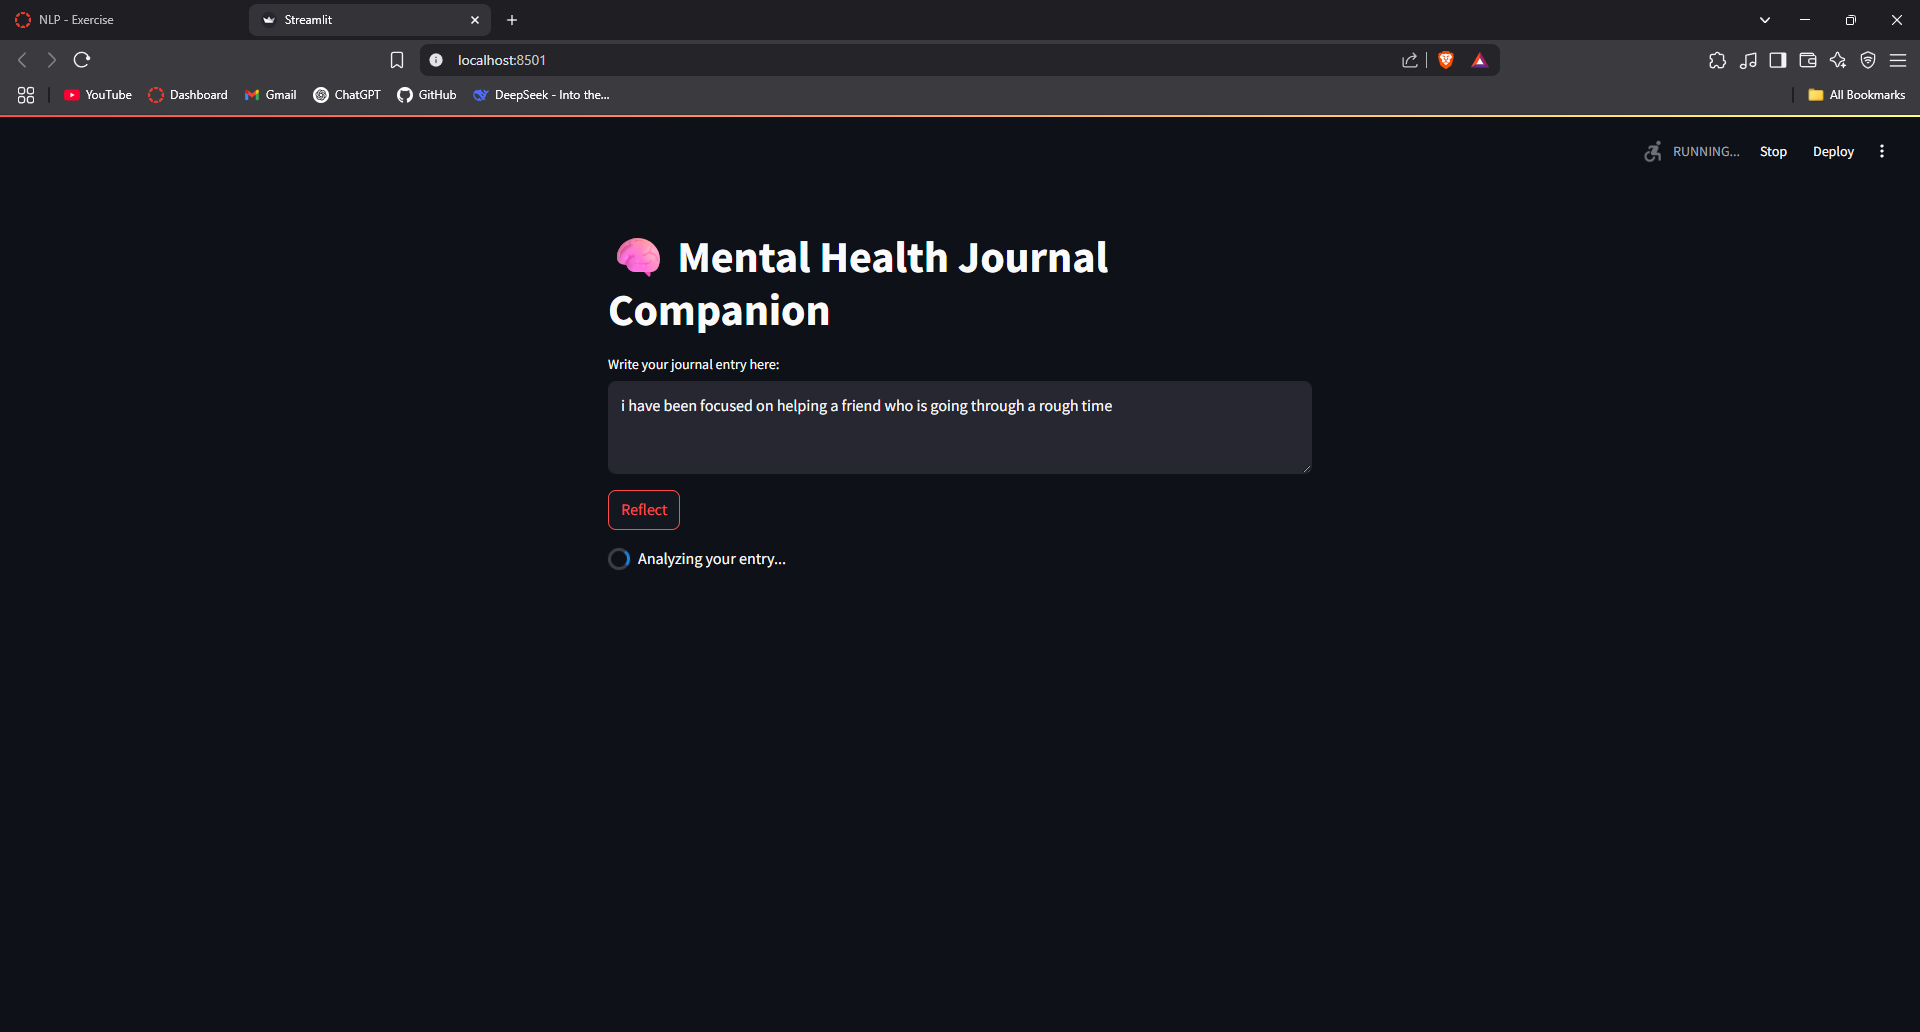

In [5]:
# Show image of when the model is generating a response
from IPython.display import Image, display
display(Image(filename='./screenshots/loading.png'))

In the above image we can see what happens after the response button is pressed.        
First the frontend shows that the entry is being analysed by the model.         
Second is the reflect button being turned red and being unusable until the model is done generating a response.         

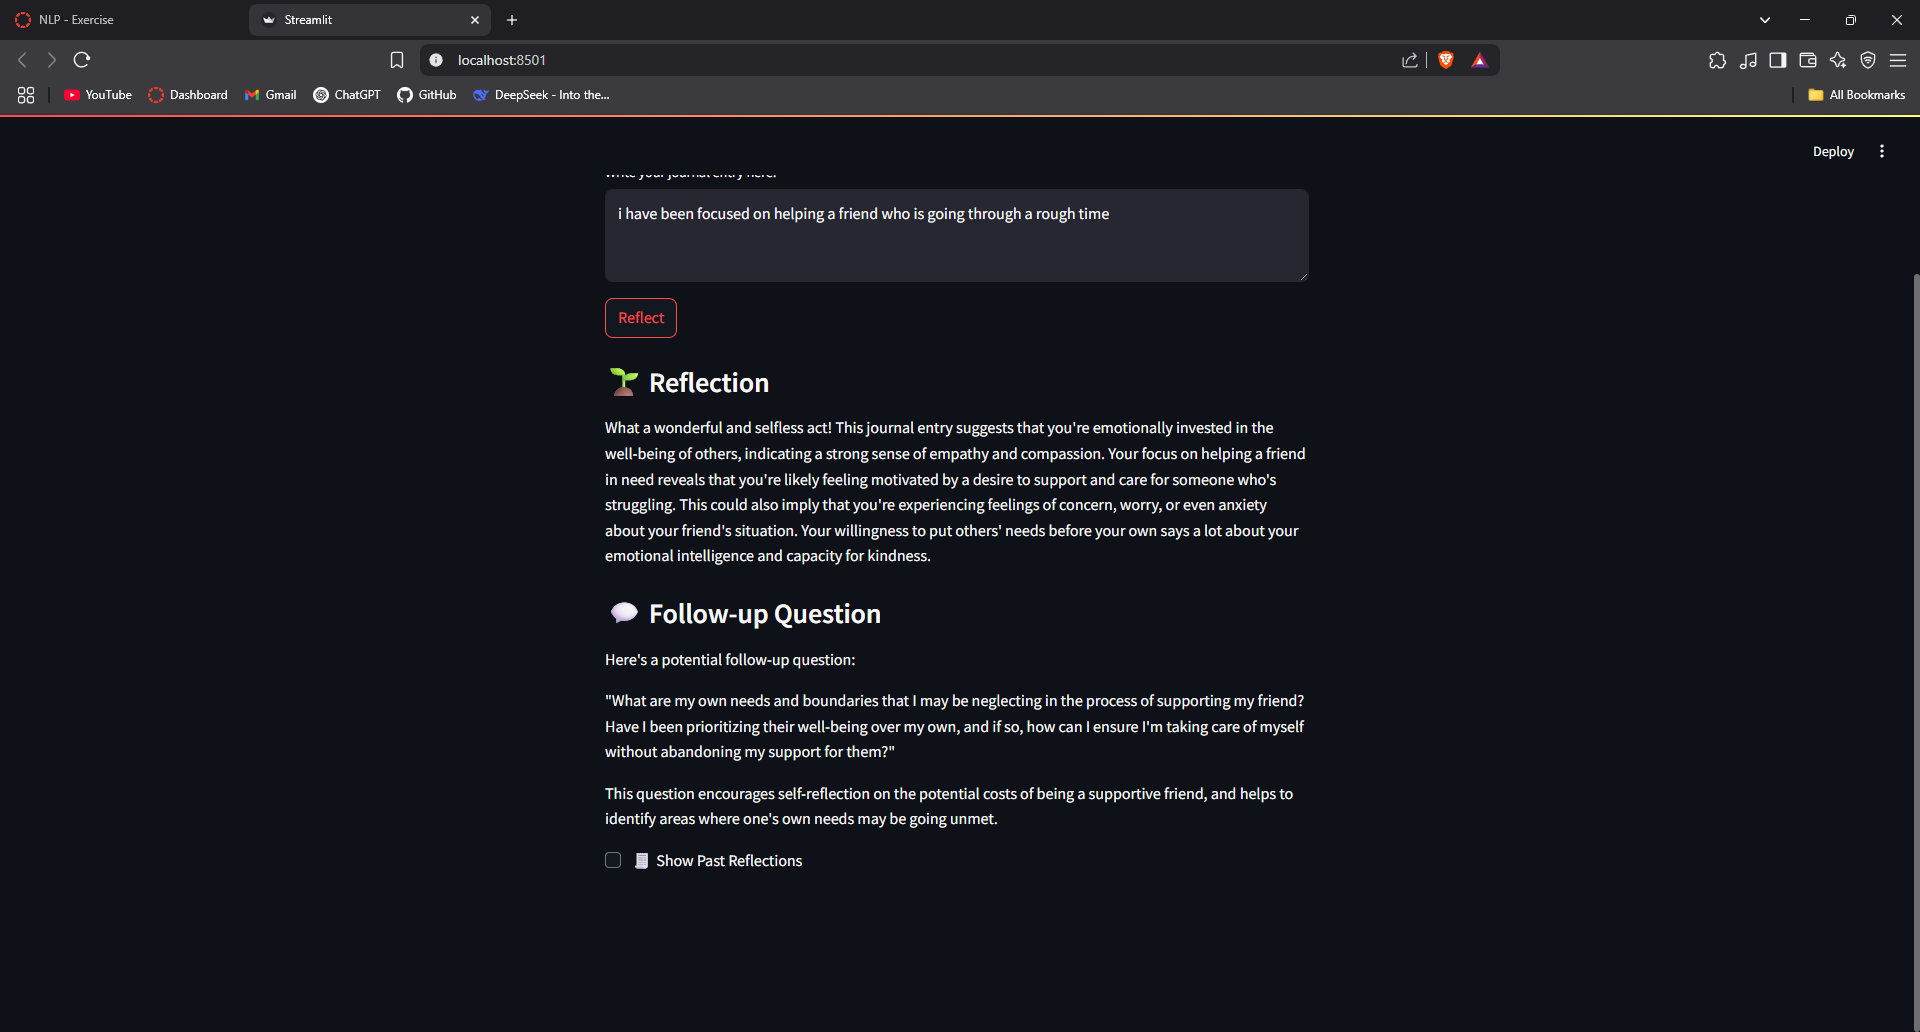

In [6]:
# Show image of when the model is generating a response
from IPython.display import Image, display
display(Image(filename='./screenshots/response.png'))

In the image above we can see what it looks like after the model is done generating a response.         
The model returns two things: a reflection and a follow-up question.        
The Reflection is a simple reflection of your journal.                  
The Follow-up question is a question generated to incentivese further self relfection by the user.

### 4. Memory System
The model's output and the user's input are stored
#### Coresponding code snippets
```python
def store_memory(entry, reflection, followup):
    memory_entry = (
        f"### Reflection\n{reflection}\n\n"
        f"### Follow-up\n{followup}"
    )
    vectorstore.add_texts([memory_entry])  # Store in FAISS
    vectorstore.save_local("faiss_index")
```

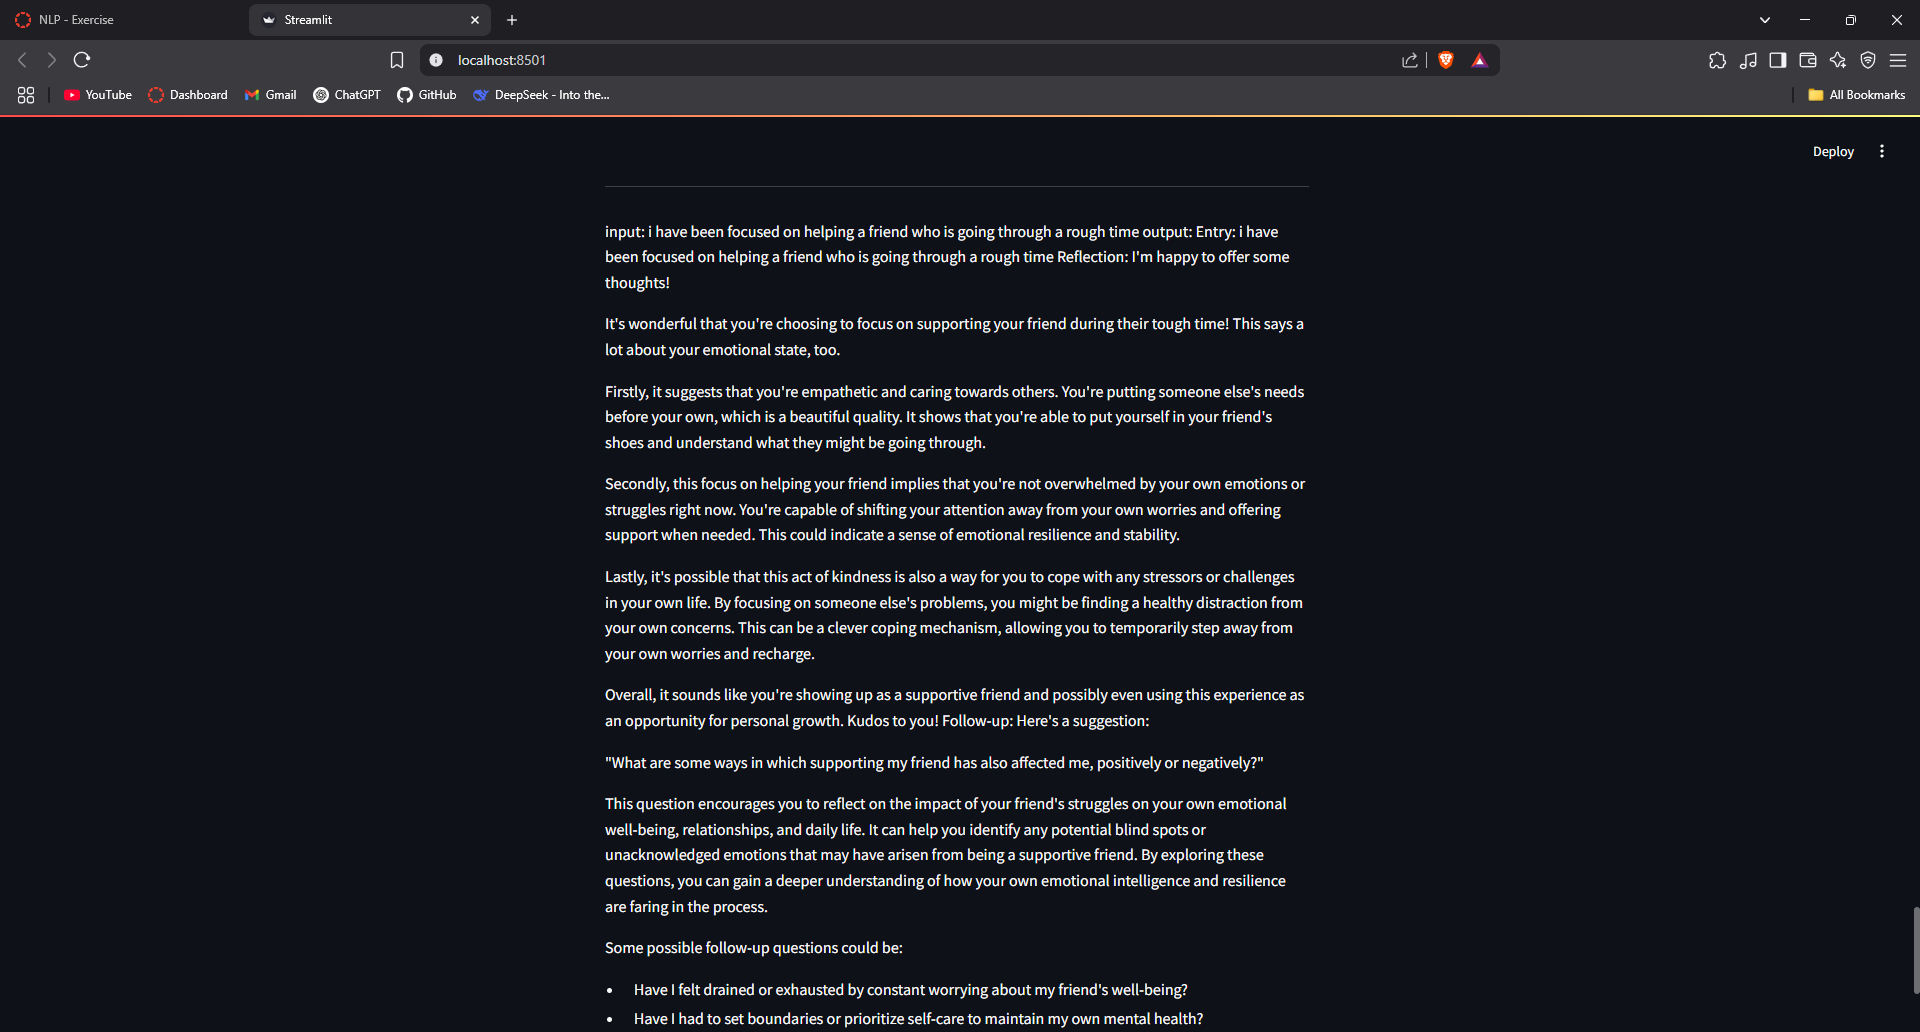

In [ ]:
# Show image of when the application shows the message history
from IPython.display import Image, display
display(Image(filename='./screenshots/history.png'))

In the Image above the memory is shown.         
The memory shows the full interaction of each message with the model.       
The journal, reflection and follow-up are shown in the frontend.        
Each interaction is sepparated by a seperator line, this allows for an easier overview.     

## Full Streamlit App Code
The full code can be found in app.py